# Libraries and Data

In [1]:
# Importing libraries
# pip install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm
from xgboost import plot_tree
from matplotlib.pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
import xgboost as xgb
from pathlib import Path

pd.options.display.max_columns=200
pd.options.display.max_rows=200

In [2]:
# Loading datafile

data_file = Path("./Data/2023_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep=",", decimal=".",index_col="Booking_ID")

In [3]:
# Descriptive characteristics and NaNs in data set

print(data.shape) # 17 predictors
data.describe().transpose() # counting predictor are all non-negative
data.isna().sum() # xgboost handles NaNs automatically

(32647, 18)


no_of_adults                             4416
no_of_children                          27604
no_of_weekend_nights                    24918
no_of_week_nights                        8360
type_of_meal_plan                       16103
required_car_parking_space              14784
room_type_reserved                      21287
lead_time                               25712
arrival_year                             2993
arrival_month                             907
arrival_date                            27190
market_segment_type                     14121
repeated_guest                          24978
no_of_previous_cancellations               69
no_of_previous_bookings_not_canceled    14621
avg_price_per_room                      23589
no_of_special_requests                   7450
booking_status                            352
dtype: int64

# Metadata definition

In [4]:
col_target = "booking_status"
col_year = "arrival_year"
col_month = "arrival_month"
col_date = "arrival_date"
data[col_year]=data[col_year].astype(object)
data[col_month]=data[col_month].astype(object)
data[col_date]=data[col_date].astype(object)
data[col_date]=data[col_date].astype(object)

# All predictors used for model building
cols_pred = list(data.columns)[0:-1] 

# Numerical and categorial predictors
cols_pred_num=list(col for col in cols_pred if data[col].dtype!="O")
cols_pred_cat=list(col for col in cols_pred if data[col].dtype=="O")

# Moving categorical variables to appropriate cols_pred variable

cols_pred_num.remove("repeated_guest")
cols_pred_num.remove("required_car_parking_space")

cols_pred_cat.append("repeated_guest")
cols_pred_cat.append("required_car_parking_space")

In [5]:
# Verifying dimensions for cols_pred_...

print(data.shape)
print(len(cols_pred_num))
print("----")
print(len(cols_pred_cat))
print(len(cols_pred))

(32647, 18)
9
----
8
17


In [6]:
# máme NaNs v našem targetu, takže tyhle řádky musíme smazat
data[col_target].isnull().sum() # počet NaNs v targetu

352

In [7]:
tobedropped=list(data.loc[data[col_target].isnull()==True].index) # všechny jednoznačené indexy řádku, kde je target NaN
data.drop(labels=tobedropped,axis=0,inplace=True) # smazat všechny řádky, kde je target nan

# Splitting data

- jelikož nemá k dispozici časové údaje, nemůžeme provést split na *hoot* a *oot* 

In [8]:
data["sample"]="default"
col_sample="sample"
month_mask=data[col_month].isna()==False
month_na_mask=data[col_month].isna()==True
dat= pd.read_csv(Path("./Data/2023_DS2_HW1_data_train.csv"), sep=",", decimal=".",index_col="Booking_ID")
#splitneme data na train, test a valid

data_train, data_rest = train_test_split(data[month_mask], train_size=0.55, stratify=(data[month_mask][[col_month,col_target]]), random_state=12)
data_valid, data_test = train_test_split(dat[month_mask], train_size=0.5, stratify = (data_rest[[col_month,col_target]]),random_state=12)

#změníme hodnoty ve sloupci sample podle toho v jaké subsamplu je dané pozorování
data.loc[data_train.index, "sample"] = "train"
data.loc[data_test.index, "sample"] = "test"
data.loc[data_valid.index, "sample"] = "valid"

# splitování na train,test,valid kde je měsíc Na
data_train, data_rest = train_test_split(data[month_na_mask], train_size=0.55, stratify=(data[month_na_mask][col_target]), random_state=12)
data_valid, data_test = train_test_split(data_rest, train_size=0.5, stratify = (data_rest[col_target]),random_state=12)

data.loc[data_train.index, "sample"] = "train"
data.loc[data_test.index, "sample"] = "test"
data.loc[data_valid.index, "sample"] = "valid"

# definujeme si pomocné masky k rychlejšímu přístupu

train_mask = data["sample"]=="train"
test_mask = data["sample"]=="test"
valid_mask = data["sample"]=="valid"

# počty pozorování v daných subsamplech
print(data[train_mask].shape)
print(data[test_mask].shape)
print(data[valid_mask].shape)

(17761, 19)
(7267, 19)
(7267, 19)


# Checking for infinities
- žádné

In [9]:
cols_with_inf=[]
cols_with_neginf=[]
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(cols_with_inf)       
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(col_with_neginf)

# Plotting data
## Plotting numerical covariates

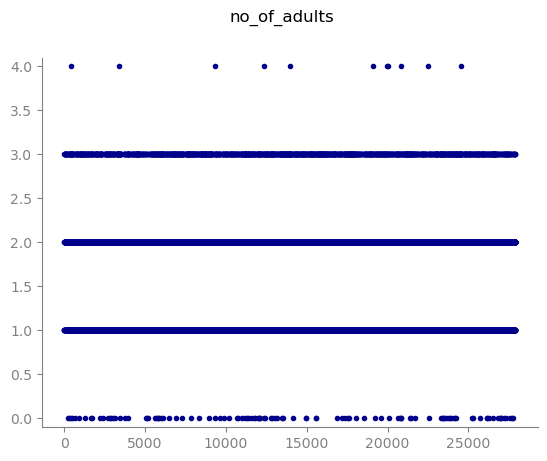

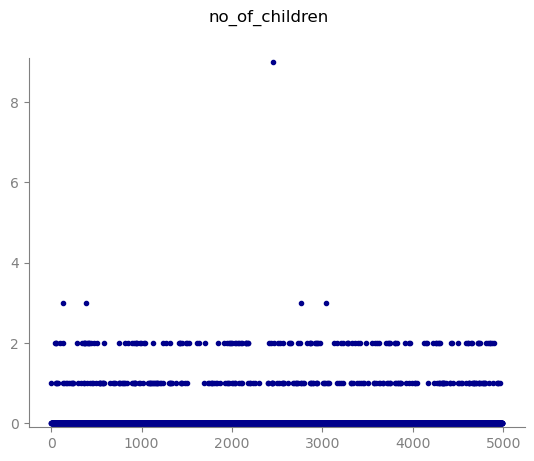

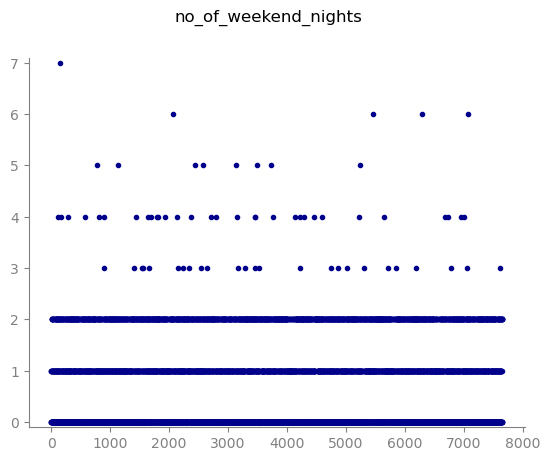

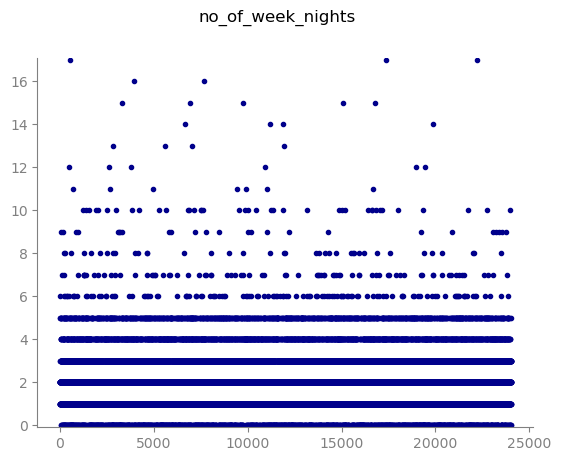

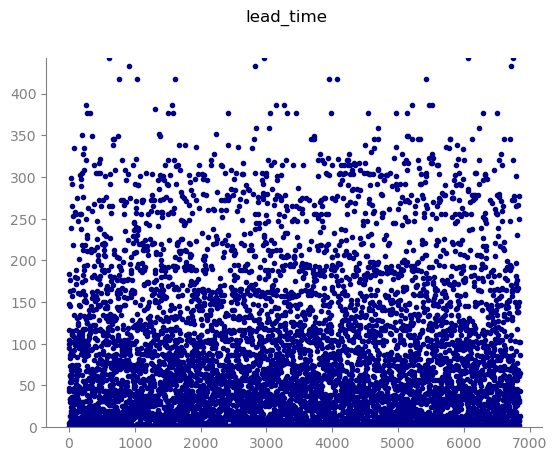

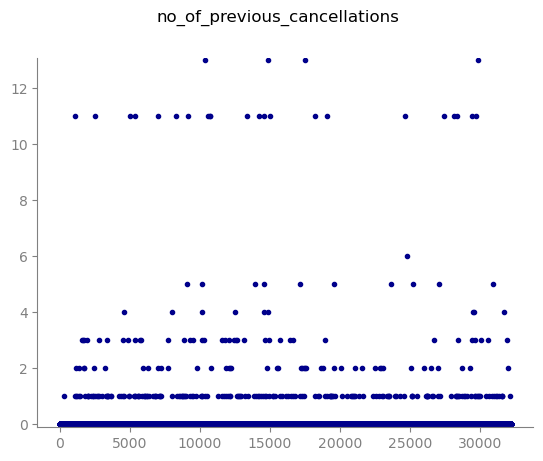

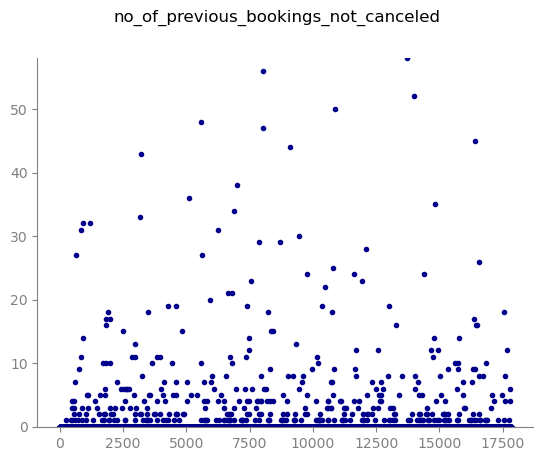

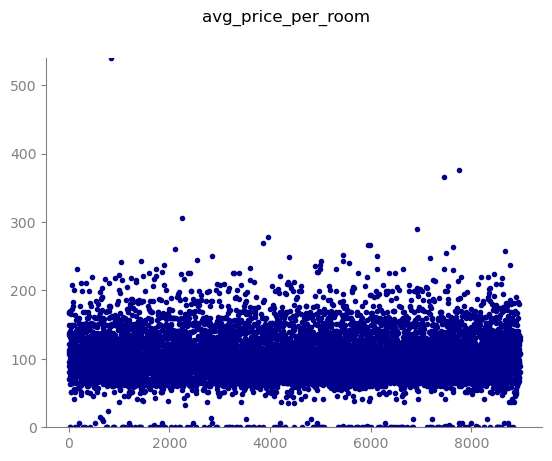

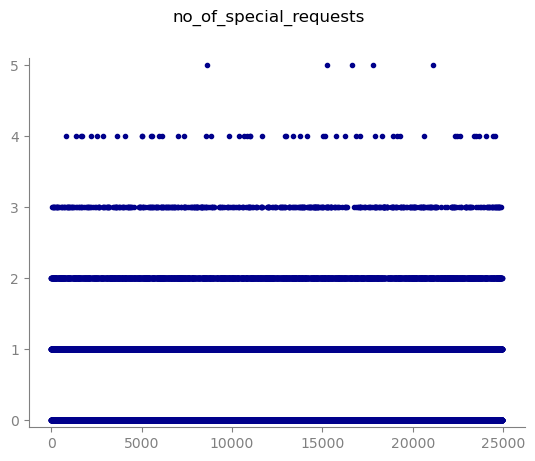

In [10]:
for col in cols_pred_num:
    plt.plot(range(len(data[col].dropna())),data[col].dropna(),marker="o",linewidth=0,markersize=3,color="darkblue")
    plt.suptitle(col)
    plt.ylim([min(data[col].dropna())-0.1,max(data[col].dropna())+0.1])
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
    
    plt.show()

## Plotting categorical covariates

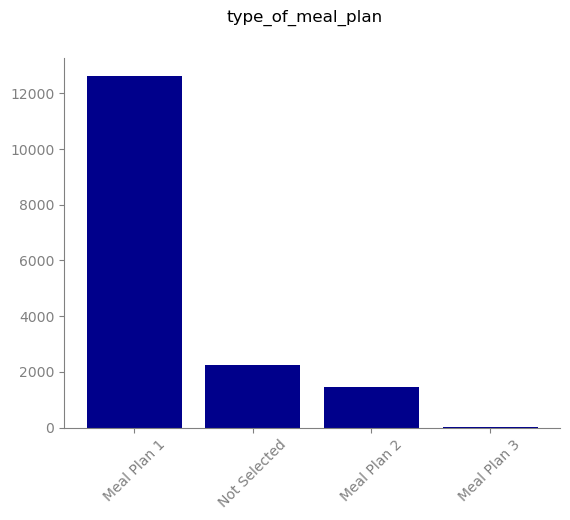

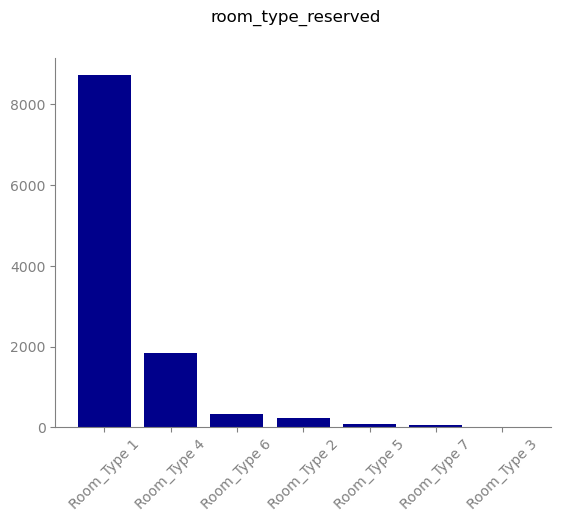

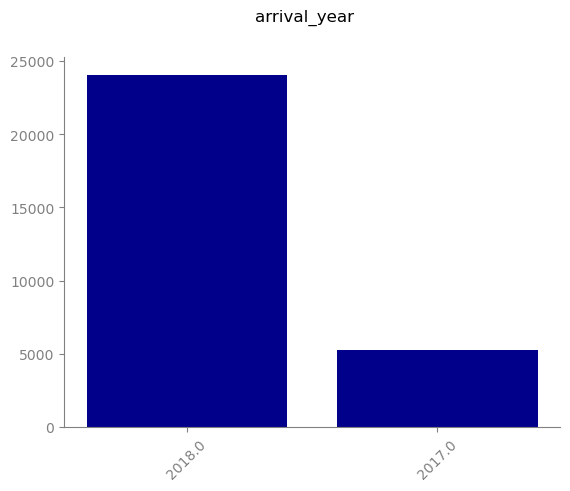

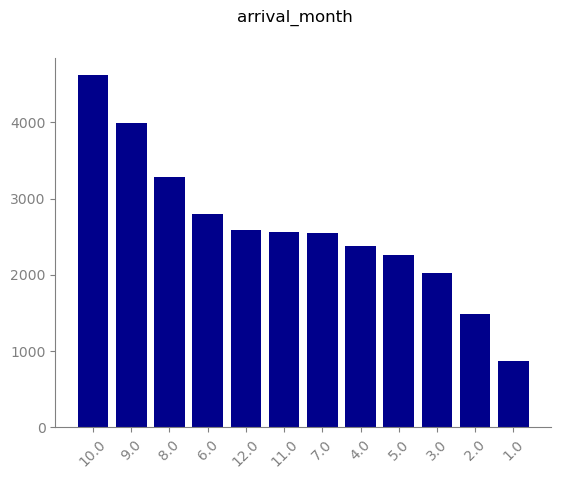

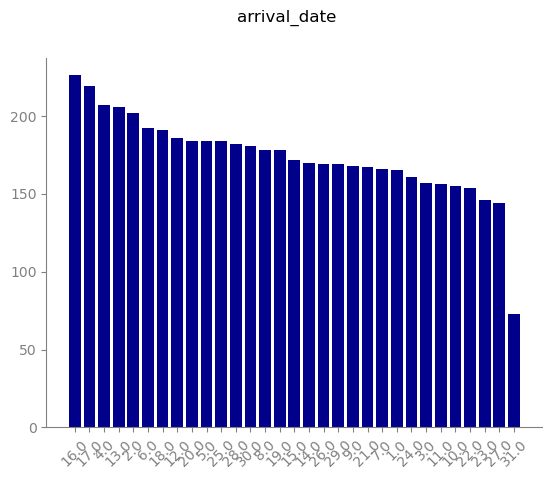

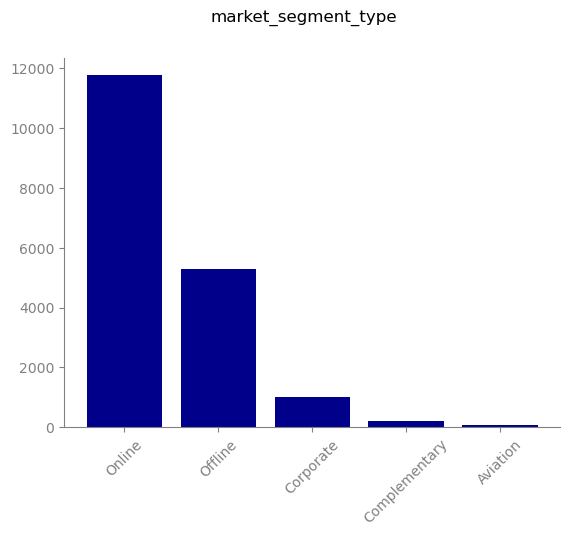

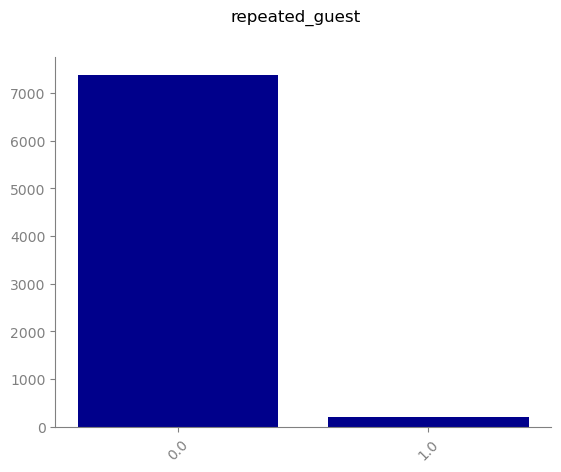

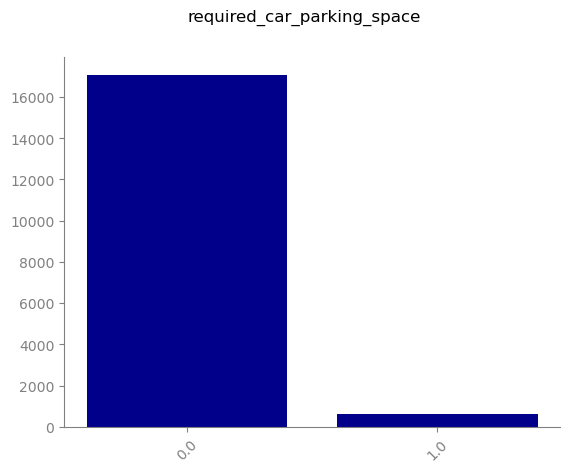

In [11]:
for col in cols_pred_cat:
    categ=list(pd.DataFrame(data[col].value_counts(dropna=True)).index)
    counts=list(pd.DataFrame(data[col].value_counts(dropna=True))[col])
    
    plt.bar(range(len(counts)), counts, color="darkblue")
    plt.xticks(range(len(categ)),categ, rotation=45)
    plt.suptitle(col)
    #plt.yscale("log")
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
    
    plt.show()

# Encoding categorical variables

In [12]:
# number of categories for each categorical variable

for col in cols_pred_cat:
    print(data[col].dropna().unique().shape)

(4,)
(7,)
(2,)
(12,)
(31,)
(5,)
(2,)
(2,)


In [13]:
# base on plotting categorical variable, we shall choose alpha based on a graph of arrival_dat, it is alpha=0.01
print(data[train_mask].shape) 
200/19377

(17761, 19)


0.010321515198431129

In [14]:
def mean_target_encoding(dt, predictor, target, alpha = 0.05):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, np.mean),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [15]:
total_dr = np.mean(data[train_mask][col_target])

# Encode categorical predictors Dummy of MTE, alpha is chosen 0.01 based on previous comment
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target,
            alpha=0.01
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].replace(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
            
# data již obsahují jak původní kategoriální veličiny, tak i upravené MTE a dummy proměnné
# data[cols_pre] obsahjí pouze nové kategoriální veličiny, tedy MTE a dummy, už by měly všechny obsahovat pouze čísla a NaNs

  0%|          | 0/8 [00:00<?, ?it/s]

# XGBoost model

- after few runs these parameters seem to be the best, based on AUC and overfitting

C:\Users\Karla\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


--------------------------------------------
The Best AUC on Valid:
0.8095631256304803

Iteration for the Best Score
98


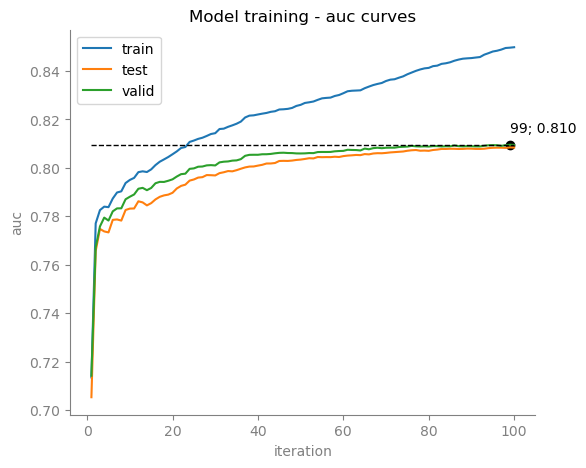

In [16]:
model=xgb.XGBClassifier(
    booster="gbtree",
    objective="binary:logistic",
    eval_metric="auc",
    verbosity=1,
    random_state=12,
    importance_type="total_gain",
    max_depth=5,
    learning_rate=0.16,
    subsample=0.7,
    colsample_bytree=0.7
)

model.fit(
    data[train_mask][cols_pred].values,
    data[train_mask][col_target].values,
    eval_set=[   
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values) #použitá pro early_stopping
    ],
    verbose = False,
    early_stopping_rounds = 30,
)

evals_result=model.evals_result()
evals_result["train"]=evals_result.pop("validation_0")
evals_result["test"]=evals_result.pop("validation_1")
evals_result["valid"]=evals_result.pop("validation_2")
print("--------------------------------------------")
print("The Best AUC on Valid:")
print(model.best_score)
print("")
print("Iteration for the Best Score")
print(model.best_iteration)
data["predicted_cr"]=model.predict_proba(data[cols_pred])[:,1]
data["predicted_score"]=np.log(data["predicted_cr"]/(1-data["predicted_cr"]))

# Plot AUC 

metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = model.best_score
best_iteration = model.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

## Feature importance

Variable: no_of_special_requests    Importance: 0.1885800063610077
Variable: MTE_arrival_month         Importance: 0.17905999720096588
Variable: lead_time                 Importance: 0.14045000076293945
Variable: MTE_arrival_year          Importance: 0.09901999682188034
Variable: avg_price_per_room        Importance: 0.08668000251054764
Variable: MTE_market_segment_type   Importance: 0.07225999981164932
Variable: no_of_week_nights         Importance: 0.06159999966621399
Variable: no_of_adults              Importance: 0.041439998894929886
Variable: MTE_type_of_meal_plan     Importance: 0.031780000776052475
Variable: MTE_arrival_date          Importance: 0.03002999909222126
Variable: no_of_previous_bookings_not_canceled Importance: 0.0177800003439188
Variable: no_of_weekend_nights      Importance: 0.014240000396966934
Variable: MTE_room_type_reserved    Importance: 0.013570000417530537
Variable: MTE_required_car_parking_space Importance: 0.011699999682605267
Variable: MTE_repeated_guest 

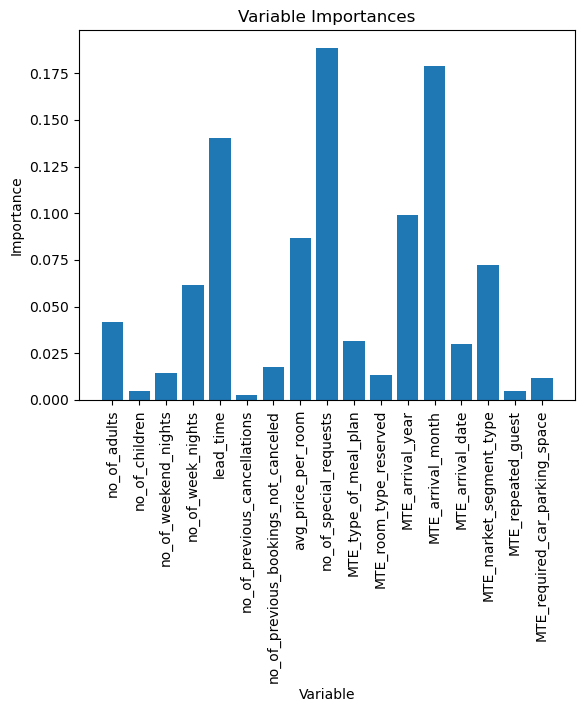

In [17]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(cols_pred, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];

# Plot importance
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, cols_pred, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [18]:
# Creating a matrix containg Feature importance = total gain and the name of an according predictor
FI=model.feature_importances_
FI=[FI,np.array(cols_pred)]
FI=pd.DataFrame(FI).transpose()
FI.columns=["Feature importance","Predictor"]
FI=FI.sort_values(by=["Feature importance"],ascending=True)
FI

,Feature importance,Predictor
5,0.002604,no_of_previous_cancellations
1,0.004561,no_of_children
15,0.004638,MTE_repeated_guest
16,0.011699,MTE_required_car_parking_space
10,0.013574,MTE_room_type_reserved
2,0.014244,no_of_weekend_nights
6,0.01778,no_of_previous_bookings_not_canceled
13,0.030035,MTE_arrival_date
9,0.03178,MTE_type_of_meal_plan
0,0.041444,no_of_adults


## Individual Trees

In [19]:
print(f"Celkový počet stromů je {model.best_iteration}.")

Celkový počet stromů je 98.


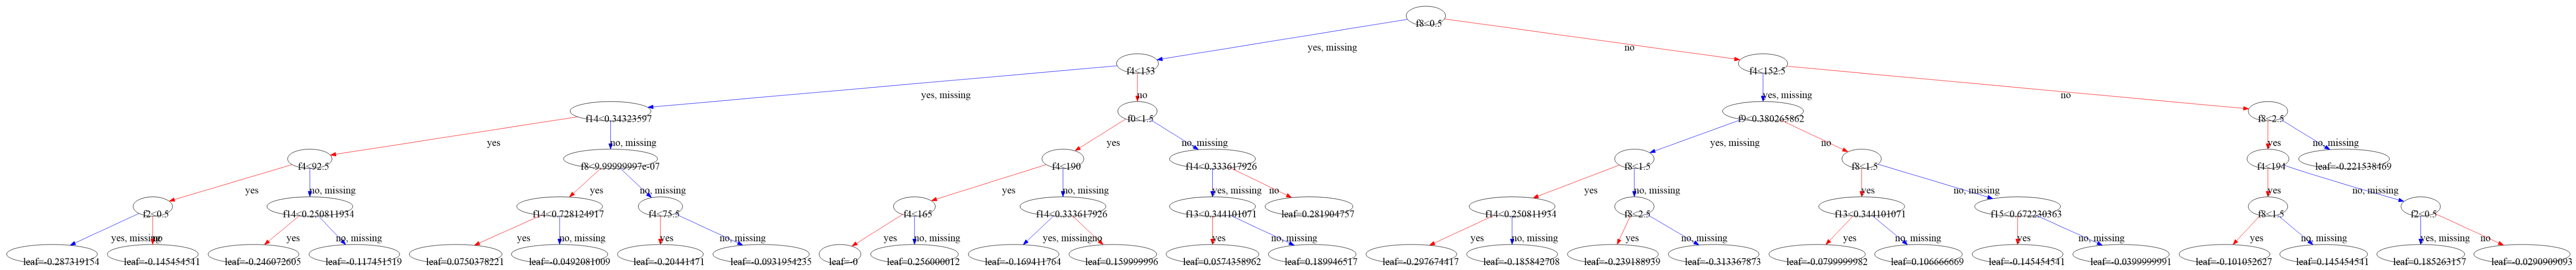

In [20]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 80,50

plot_tree(model, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

## Score Distribution

In [21]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin').agg(
        bad_cnt = (col_target, sum),
        tot_cnt = (col_target, len),
        def_rt = (col_target, np.mean),
        avg_score = (col_score, np.mean)
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

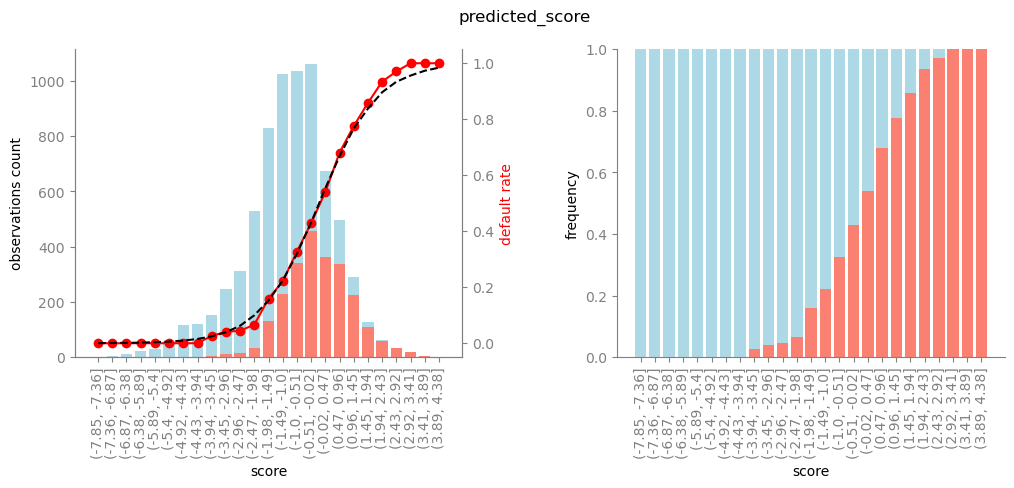

In [22]:
# Default rate for bins of predicted scores for each client
plot_score_calibration(data[test_mask],"predicted_score",col_target)

## Marginal Contribution

In [23]:
def fit_model(predictors):
    params={
        'eta': 0.16,
        'max_depth': 5,
        "subsample":0.7,
        "colsample_bytree":0.7,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        verbose_eval=False,
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 30
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction=model.predict_proba(data[test_mask][cols_pred],iteration_range=(0,model.best_iteration))[:,1]
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))
    
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)
marginal_contribution

  0%|          | 0/17 [00:00<?, ?it/s]

[('no_of_weekend_nights', -0.0016702016674857711),
 ('MTE_room_type_reserved', -0.0015290602933188957),
 ('no_of_previous_bookings_not_canceled', -0.0014679306450083862),
 ('no_of_previous_cancellations', -0.0009788934585240883),
 ('MTE_arrival_date', -0.000842795926989437),
 ('MTE_repeated_guest', -0.0004952018830346461),
 ('no_of_children', 0.00010846417147325482),
 ('MTE_type_of_meal_plan', 0.0015917850029745217),
 ('MTE_required_car_parking_space', 0.0016391626359034683),
 ('no_of_adults', 0.003585439245406663),
 ('no_of_week_nights', 0.004315589353612204),
 ('avg_price_per_room', 0.008367821146202381),
 ('lead_time', 0.012150013364027323),
 ('MTE_market_segment_type', 0.012875680056560035),
 ('MTE_arrival_year', 0.01726580619573559),
 ('MTE_arrival_month', 0.031059379391807362),
 ('no_of_special_requests', 0.060715363458437865)]

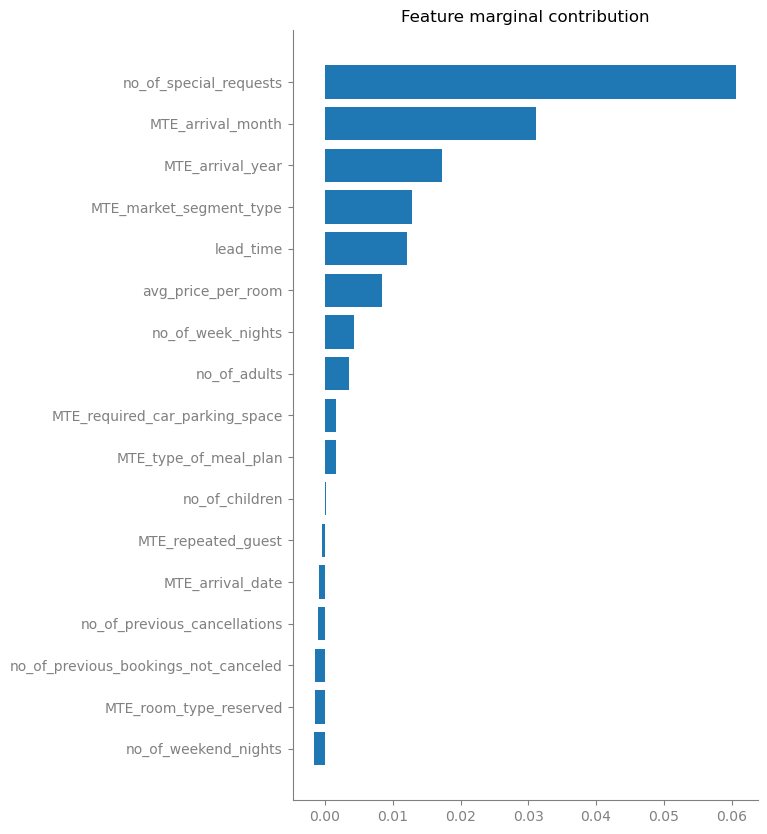

In [24]:
plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

## Marginal Contribution vs Feature importance

In [25]:
MC=pd.DataFrame(marginal_contribution,columns=["Predictor","Marginal Contribution"])
MC

,Predictor,Marginal Contribution
0,no_of_weekend_nights,-0.001670
1,MTE_room_type_reserved,-0.001529
2,no_of_previous_bookings_not_canceled,-0.001468
3,no_of_previous_cancellations,-0.000979
4,MTE_arrival_date,-0.000843
5,MTE_repeated_guest,-0.000495
6,no_of_children,0.000108
7,MTE_type_of_meal_plan,0.001592
8,MTE_required_car_parking_space,0.001639
9,no_of_adults,0.003585


In [26]:
FI # při porovnání tabulek dostaneme, že vlastně tak jak to smažeme v kapitole 8 je v pohodě a marginal contribution mají také špatné hodnody

,Feature importance,Predictor
5,0.002604,no_of_previous_cancellations
1,0.004561,no_of_children
15,0.004638,MTE_repeated_guest
16,0.011699,MTE_required_car_parking_space
10,0.013574,MTE_room_type_reserved
2,0.014244,no_of_weekend_nights
6,0.01778,no_of_previous_bookings_not_canceled
13,0.030035,MTE_arrival_date
9,0.03178,MTE_type_of_meal_plan
0,0.041444,no_of_adults


# Define new cols_pred
- zadefinujeme si nové cols_pred, které měli vyšší feature importance

In [27]:
FI=model.feature_importances_
FI=[FI,np.array(cols_pred)]
FI=pd.DataFrame(FI).transpose()
FI.columns=["Feature importance","Predictor"]
FI=FI.sort_values(by=["Feature importance"],ascending=False)
FI

,Feature importance,Predictor
8,0.188577,no_of_special_requests
12,0.179062,MTE_arrival_month
4,0.140446,lead_time
11,0.099021,MTE_arrival_year
7,0.086678,avg_price_per_room
14,0.072257,MTE_market_segment_type
3,0.061601,no_of_week_nights
0,0.041444,no_of_adults
9,0.03178,MTE_type_of_meal_plan
13,0.030035,MTE_arrival_date


In [28]:
cols_pred=list(FI.loc[FI["Feature importance"]>0.027,"Predictor"])
cols_pred_num=list(col for col in cols_pred if col.startswith("MTE")==False)
cols_pred_cat=list(col for col in cols_pred if col.startswith("MTE")==True)

# Final XGBoost model
- 0.813

    booster="gbtree",
    objective="binary:logistic",
    eval_metric="auc",
    verbosity=1,
    random_state=12,
    importance_type="total_gain",
    max_depth=6,
    learning_rate=0.15,
    subsample=0.6,
    colsample_bytree=0.6

C:\Users\Karla\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


--------------------------------------------
The Best AUC on Valid:
0.8088226291784141

Iteration for the Best Score
92


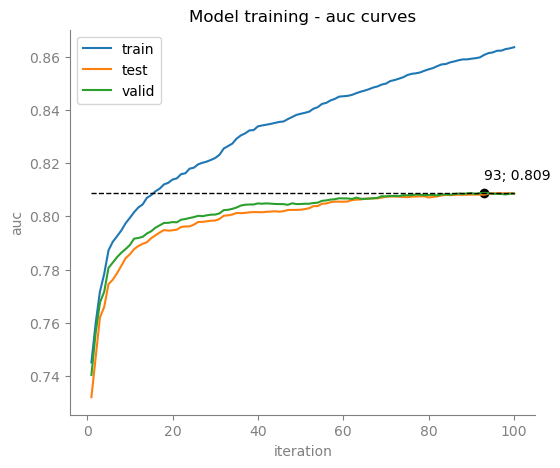

In [56]:
final_model=xgb.XGBClassifier(
    booster="gbtree",
    objective="binary:logistic",
    eval_metric="auc",
    verbosity=1,
    random_state=12,
    importance_type="total_gain",
    max_depth=5,
    learning_rate=0.25,
    subsample=0.8,
    colsample_bytree=0.9
)

final_model.fit(
    data[train_mask][cols_pred].values,
    data[train_mask][col_target].values,
    eval_set=[   
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values) #použitá pro early_stopping
    ],
    verbose = False,
    early_stopping_rounds = 30,
)

evals_result=final_model.evals_result()
evals_result["train"]=evals_result.pop("validation_0")
evals_result["test"]=evals_result.pop("validation_1")
evals_result["valid"]=evals_result.pop("validation_2")
print("--------------------------------------------")
print("The Best AUC on Valid:")
print(final_model.best_score)
print("")
print("Iteration for the Best Score")
print(final_model.best_iteration)
data["predicted_cr"]=final_model.predict_proba(data[cols_pred])[:,1]
data["predicted_score"]=np.log(data["predicted_cr"]/(1-data["predicted_cr"]))

# Plot AUC 

metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = final_model.best_score
best_iteration = final_model.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

## Feature importance

Variable: MTE_arrival_month         Importance: 0.1872716099023819
Variable: no_of_special_requests    Importance: 0.18046921491622925
Variable: lead_time                 Importance: 0.1440291702747345
Variable: avg_price_per_room        Importance: 0.11936641484498978
Variable: MTE_arrival_year          Importance: 0.10306040197610855
Variable: MTE_market_segment_type   Importance: 0.0807112529873848
Variable: no_of_week_nights         Importance: 0.07119239121675491
Variable: no_of_adults              Importance: 0.047934066504240036
Variable: MTE_type_of_meal_plan     Importance: 0.03472946956753731
Variable: MTE_arrival_date          Importance: 0.031236063688993454


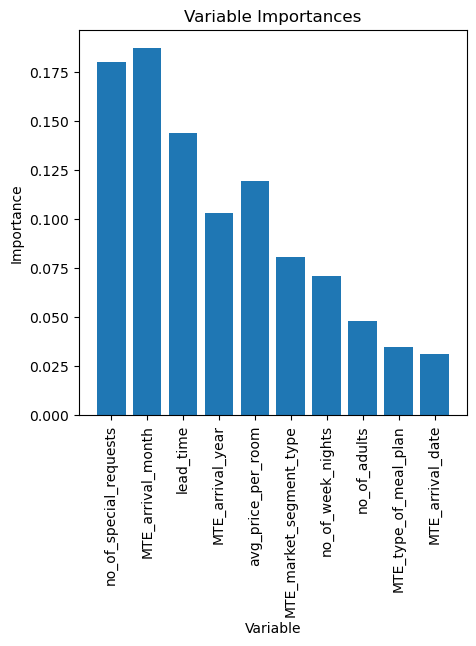

In [57]:
# Get numerical feature importances
importances = list(final_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(cols_pred, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];

# Plot importance
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, cols_pred, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Score Distribution

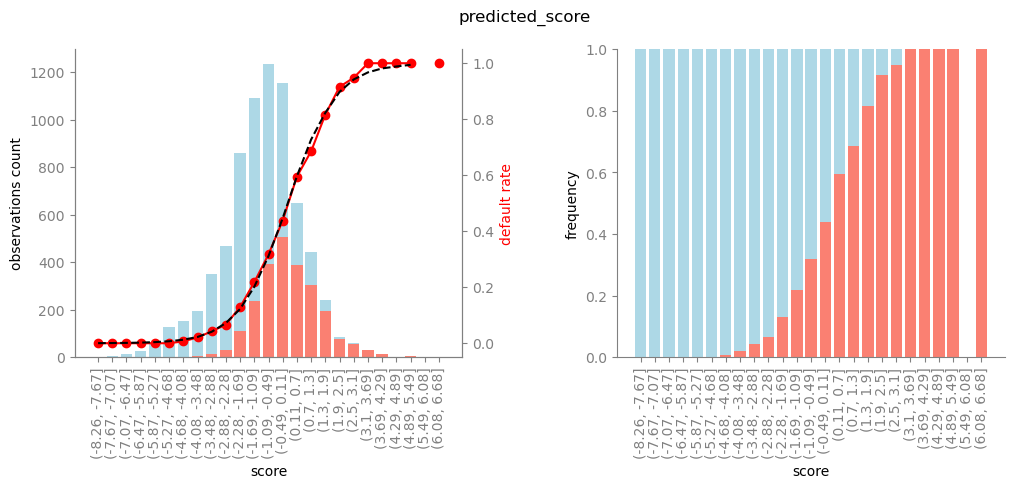

In [58]:
plot_score_calibration(data[test_mask],"predicted_score",col_target)

## Permutation Importance
- o kolik se vychýlí AUC po zatřesení daného regresoru

In [59]:
r = permutation_importance(final_model, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=6)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cols_pred[i]:<8}    "
              f"{r.importances_mean[i]:.4f}"
              f" +/- {r.importances_std[i]:.4f}")

no_of_special_requests    0.0760 +/- 0.0038
MTE_arrival_month    0.0341 +/- 0.0026
lead_time    0.0263 +/- 0.0017
MTE_arrival_year    0.0263 +/- 0.0037
MTE_market_segment_type    0.0214 +/- 0.0027
avg_price_per_room    0.0148 +/- 0.0011
no_of_week_nights    0.0141 +/- 0.0012
no_of_adults    0.0103 +/- 0.0014
MTE_type_of_meal_plan    0.0063 +/- 0.0012


## Marginal Contribution

In [60]:
def fit_model(predictors):
    params={
        'eta': 0.15,
        'max_depth': 3,
        "subsample":0.8,
        "colsample_bytree":0.8,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        verbose_eval=False,
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 30
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction=final_model.predict_proba(data[test_mask][cols_pred],iteration_range=(0,final_model.best_iteration))[:,1]
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))
    
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)
marginal_contribution

  0%|          | 0/10 [00:00<?, ?it/s]

[('MTE_arrival_date', -0.0005953458696533742),
 ('MTE_type_of_meal_plan', 0.0023392221273808023),
 ('no_of_adults', 0.007691816904201509),
 ('no_of_week_nights', 0.009651112663062733),
 ('avg_price_per_room', 0.012983325142477797),
 ('MTE_market_segment_type', 0.01564418923462929),
 ('lead_time', 0.017474026365932982),
 ('MTE_arrival_year', 0.021749954734745613),
 ('MTE_arrival_month', 0.031446548201029545),
 ('no_of_special_requests', 0.06483609666933954)]

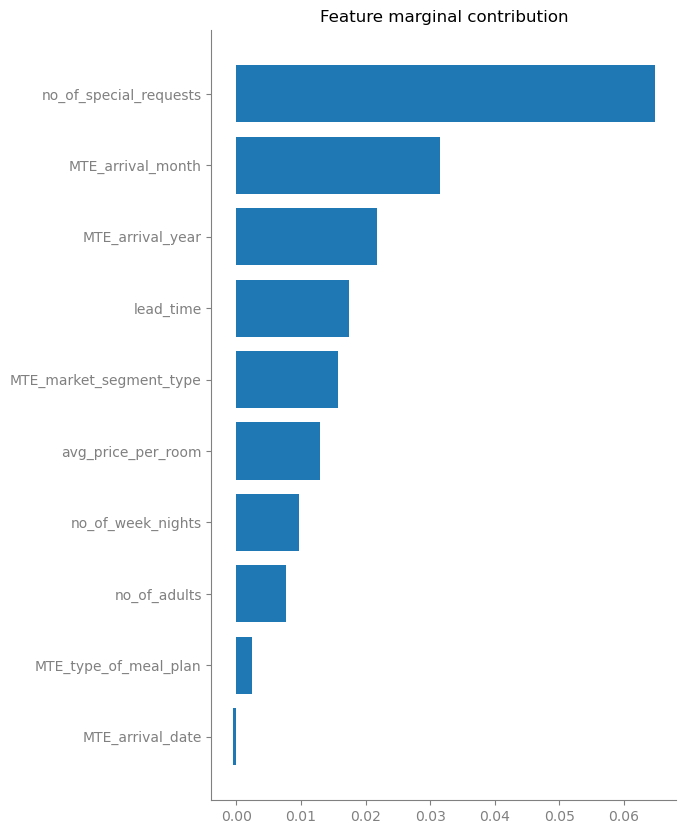

In [61]:
plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

# Predictions

In [62]:
data_test_file=Path("./Data/2023_DS2_HW1_data_test.csv")
data_test=pd.read_csv(data_test_file,sep=",",decimal=".",index_col="Booking_ID")

In [63]:
data_test.describe().transpose()
data_test.shape

(3593, 17)

In [64]:
cols_pred_test = list(data_test.columns)

# Numerical and categorial predictors
cols_pred_num_test=list(col for col in cols_pred_test if data_test[col].dtype!="O")
cols_pred_cat_test=list(col for col in cols_pred_test if data_test[col].dtype=="O")

# Moving categorical variables to appropriate cols_pred_test variable

cols_pred_num_test.remove("repeated_guest")
cols_pred_num_test.remove("required_car_parking_space")
cols_pred_num_test.remove(col_year)
cols_pred_num_test.remove(col_month)
cols_pred_num_test.remove(col_date)

cols_pred_cat_test.append("repeated_guest")
cols_pred_cat_test.append("required_car_parking_space")
cols_pred_cat_test.append(col_year)
cols_pred_cat_test.append(col_month)
cols_pred_cat_test.append(col_date)

In [65]:
cols_with_inf=[]
cols_with_neginf=[]
for col in cols_pred_num_test:
    if np.any(np.isinf(data_test[col])):
        cols_with_inf.append(col)
        print(cols_with_inf)       
for col in cols_pred_num_test:
    if np.any(np.isneginf(data_test[col])):
        cols_with_neginf.append(col)
        print(col_with_neginf)

In [66]:
total_dr = np.mean(data[train_mask][col_target])

# Encode categorical predictors Dummy of MTE, alpha is chosen 0.01 based on previous comment
for pred in tqdm(cols_pred_cat_test):
    if len(data_test[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data_test[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data_test[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data_test.columns:
                del data_test[d]
                
        data_test = data_test.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred_test:
                cols_pred_test.append(col)
        
        if pred in cols_pred_test:
            cols_pred_test.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target,
            alpha=0.01
        )

        additional_values = set(data_test[data_test[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data_test['MTE_' + pred] = data_test[pred].replace(new_vals)
        
        if 'MTE_' + pred not in cols_pred_test:
            cols_pred_test.append('MTE_' + pred)
        
        if pred in cols_pred_test:
            cols_pred_test.remove(pred)
            
# data již obsahují jak původní kategoriální veličiny, tak i upravené MTE a dummy proměnné
# data[cols_pre] obsahjí pouze nové kategoriální veličiny, tedy MTE a dummy, už by měly všechny obsahovat pouze čísla a NaNs

  0%|          | 0/8 [00:00<?, ?it/s]

In [67]:
data_test[cols_pred_test]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,MTE_type_of_meal_plan,MTE_room_type_reserved,MTE_market_segment_type,MTE_repeated_guest,MTE_required_car_parking_space,MTE_arrival_year,MTE_arrival_month,MTE_arrival_date
Booking_ID,,,,,,,,,,,,,,,,,
INN04969,2.0,NaN,1.0,0.0,NaN,0.0,NaN,NaN,3.0,0.315789,NaN,NaN,NaN,NaN,0.156533,0.384393,0.326762
INN34541,2.0,0.0,NaN,2.0,NaN,0.0,0.0,NaN,NaN,0.315789,NaN,0.303174,NaN,0.330475,0.364766,0.270056,NaN
INN36109,2.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN,NaN,0.315789,NaN,NaN,NaN,0.330475,0.364766,0.151831,NaN
INN01554,2.0,NaN,0.0,3.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.364062,NaN,0.330475,0.364766,0.391267,0.317320
INN24975,2.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,0.330475,0.364766,0.324630,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN29523,1.0,NaN,NaN,2.0,39.0,0.0,NaN,87.00,NaN,0.435359,0.325230,0.303174,NaN,0.330475,0.156533,0.384393,NaN
INN25061,2.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.325173,NaN,0.364062,0.336115,0.330475,0.364766,0.391267,NaN
INN08475,2.0,NaN,NaN,NaN,308.0,0.0,0.0,78.30,NaN,NaN,NaN,0.364062,NaN,NaN,0.364766,0.294256,NaN


In [68]:
cols_pred_test=list(FI.loc[FI["Feature importance"]>0.027,"Predictor"])
cols_pred_num_test=list(col for col in cols_pred_test if col.startswith("MTE")==False)
cols_pred_cat_test=list(col for col in cols_pred_test if col.startswith("MTE")==True)

In [69]:
data_test[col_target]=final_model.predict_proba(data_test[cols_pred_test])[:,1]

In [70]:
final=pd.DataFrame(data_test[col_target])
final.loc[final[col_target]>0.35]=1
final.loc[final[col_target]<=0.35]=0
final.describe()

,booking_status
count,3593.000000
mean,0.404954
std,0.490953
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [71]:
data[col_target].describe()

count    32295.000000
mean         0.325778
std          0.468672
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: booking_status, dtype: float64

In [72]:
final.to_csv("final.csv",index=True)